# Portfolio Analytics & Optimization

### Abstract
This project applies Modern Portfolio Theory (MPT) to real financial market data in order to analyze risk–return characteristics, construct optimal portfolios, and evaluate assets using the Capital Asset Pricing Model (CAPM). The study integrates financial theory, statistical modeling, and Python-based optimization techniques.

## 1. Introduction

Portfolio management focuses on allocating capital across assets to balance expected return and risk. Modern Portfolio Theory, introduced by Harry Markowitz, provides a mathematical framework for diversification. This project demonstrates the practical implementation of these concepts using real-world data.

In [25]:
# Cell 1: Imports & Plot Setup

import sys
sys.path.append("../src") # Project modules are stored in src/ and imported to keep the notebook clean and reusable.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Project modules
from data_ingestion import fetch_data
import portfolio_core as pc

# Plot settings
plt.rcParams["figure.figsize"] = (10, 6)

# Risk-free rate
rf = 0.04



## Data Description

The dataset consists of adjusted daily closing prices for multiple stocks and a market benchmark. Adjusted prices account for dividends and stock splits.

In [15]:
# Cell 2: Load & Inspect Data

stocks, benchmark, metadata = fetch_data()

display(
    stocks.shape, stocks.head(), stocks.tail(),
    benchmark.shape, benchmark.head(), benchmark.tail()
)


(1239, 5)

Ticker,HCLTECH.NS,AXISBANK.NS,RELIANCE.NS,BHARTIARTL.NS,SUNPHARMA.NS
Date,,,,,
2021-01-27,781.137268,629.471741,859.252258,547.595825,541.128296
2021-01-28,763.519897,667.911316,850.886414,547.691833,535.952515
2021-01-29,747.210327,660.143616,835.197693,531.095093,556.703064
2021-02-01,758.941711,706.400513,859.388245,555.606506,560.454407
2021-02-02,780.442566,711.230347,873.217957,574.985229,578.783203


Ticker,HCLTECH.NS,AXISBANK.NS,RELIANCE.NS,BHARTIARTL.NS,SUNPHARMA.NS
Date,,,,,
2026-01-20,1687.300049,1293.500000,1394.000000,1996.000000,1613.800049
2026-01-21,1682.500000,1284.900024,1404.599976,1996.099976,1612.900024
2026-01-22,1703.099976,1294.800049,1402.500000,2002.199951,1634.199951
2026-01-23,1707.000000,1258.000000,1386.099976,1984.699951,1631.900024
2026-01-27,1720.199951,1315.800049,1380.500000,1973.400024,1638.900024


(1239, 1)

Ticker,^NSEI
Date,
2021-01-27,13967.500000
2021-01-28,13817.549805
2021-01-29,13634.599609
2021-02-01,14281.200195
2021-02-02,14647.849609


Ticker,^NSEI
Date,
2026-01-20,25232.500000
2026-01-21,25157.500000
2026-01-22,25289.900391
2026-01-23,25048.650391
2026-01-27,25175.400391


## Visualizing adjusted prices helps to:

- Identify abnormal spikes or data issues
- Compare relative volatility across assets
- Observe long-term price trends

Note: Stock prices are non-stationary (their mean and variance change over time), so they cannot be used directly for optimization.

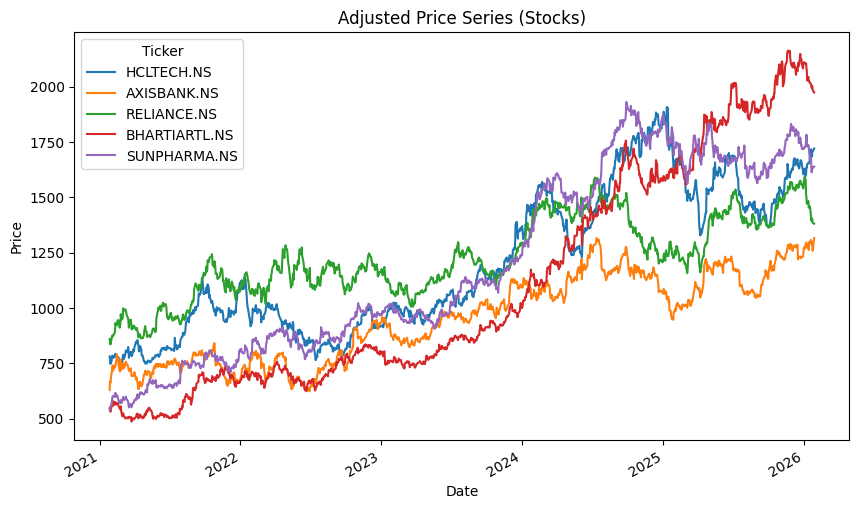

In [16]:
# Cell 3: Stock Price Series

stocks.plot()
plt.title("Adjusted Price Series (Stocks)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


Since prices are non-stationary and unsuitable for risk modeling, we transform price series into returns

## 2. Returns and Risk Metrics

We compute:
- **Log returns** - Time additive (Suitable for continuous compounding)
- **Annualized expected returns**
- **Annualized volatility**

These form the foundation of modern portfolio theory.


In [17]:
# Cell 4: Returns & Annualized Statistics

returns, mu, sigma = pc.prepare_returns(stocks)

summary = pd.DataFrame({
    "Expected Annual Return": mu,
    "Annual Volatility": np.sqrt(np.diag(sigma))
}).sort_values("Expected Annual Return", ascending=False)

summary


,Expected Annual Return,Annual Volatility
Ticker,,
BHARTIARTL.NS,0.260951,0.223657
SUNPHARMA.NS,0.225563,0.206967
HCLTECH.NS,0.160695,0.237393
AXISBANK.NS,0.150084,0.248419
RELIANCE.NS,0.096513,0.225106


## 3. Correlation Analysis

Correlation reveals how assets move relative to each other.
Lower correlation improves diversification benefits.


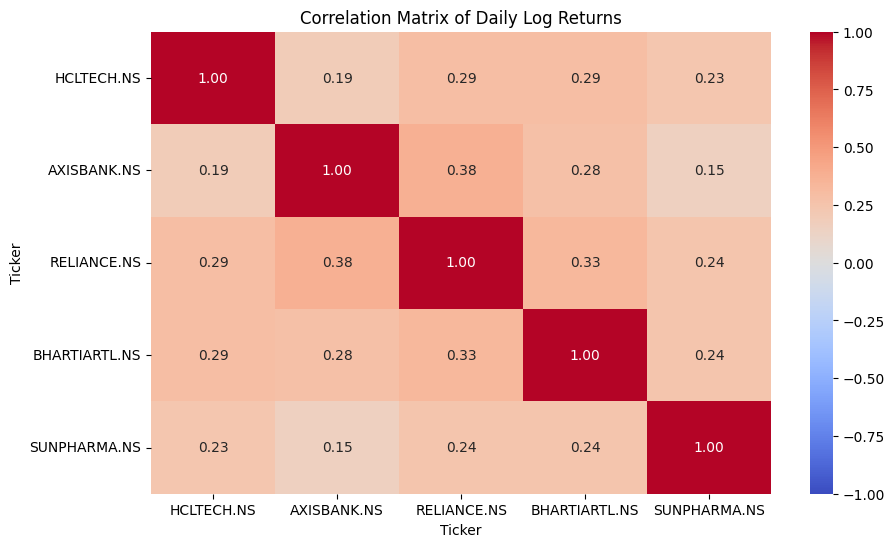

In [18]:
# Cell 5: Correlation Matrix

corr = returns.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Log Returns")
plt.show()


Low to moderate correlations indicate diversification benefits

Highly correlated stocks reduce portfolio efficiency

## 4. Random Portfolios & Efficient Frontier

We now visualize:
- Random feasible portfolios
- Efficient frontier
- Optimal portfolios (GMVP & Tangency)
- Individual stocks


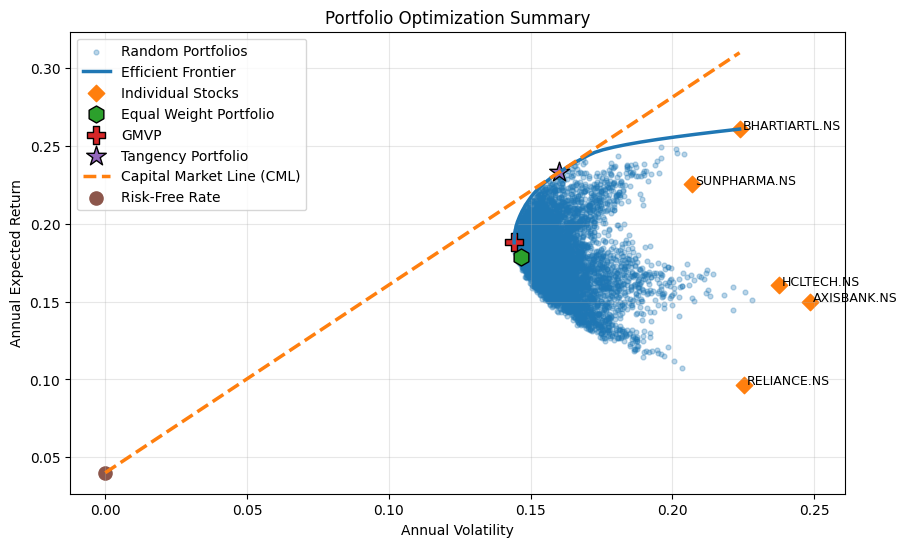

In [19]:
# Cell 6: Portfolio Optimization Summary

# Simulations & frontier
rand = pc.simulate_random_portfolios(mu, sigma, n=5000, rf=rf)
frontier = pc.efficient_frontier(mu, sigma)

# Portfolio Weights
ew   = np.ones(len(mu)) / len(mu)
gmvp = pc.global_min_variance(mu, sigma)
tan = pc.max_sharpe_ratio(mu, sigma, rf)

# Portfolio performance
ew_r, ew_v, ew_s = pc.portfolio_performance(ew, mu, sigma, rf)
gmvp_r, gmvp_v, gmvp_s = pc.portfolio_performance(gmvp, mu, sigma, rf)
tan_r, tan_v, tan_s = pc.portfolio_performance(tan, mu, sigma, rf)

# Plot
plt.scatter(rand.volatility, rand["return"], s=12, alpha=0.3, label="Random Portfolios")
plt.plot(frontier.volatility, frontier["return"], lw=2.5, label="Efficient Frontier")

plt.scatter(np.sqrt(np.diag(sigma)), mu, marker="D", s=70, label="Individual Stocks")
for v, r, n in zip(np.sqrt(np.diag(sigma)), mu, stocks.columns):
    plt.text(v + 0.001, r, n, fontsize=9)

plt.scatter(ew_v, ew_r, marker="h", s=150, edgecolors="black", label="Equal Weight Portfolio")
plt.scatter(gmvp_v, gmvp_r, marker="P", s=150, edgecolors="black", label="GMVP")
plt.scatter(tan_v, tan_r, marker="*", s=220, edgecolors="black", label="Tangency Portfolio")

# Capital Market Line (CML)
cml_x = np.linspace(0, frontier.volatility.max(), 100)
plt.plot(cml_x, rf + (tan_r - rf) / tan_v * cml_x, "--", lw=2.5, label="Capital Market Line (CML)")
plt.scatter(0, rf, s=90, label="Risk-Free Rate")

plt.xlabel("Annual Volatility")
plt.ylabel("Annual Expected Return")
plt.title("Portfolio Optimization Summary")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


This plot illustrates the risk–return landscape of all feasible portfolios. Random portfolios show the achievable region, while the efficient frontier represents portfolios that deliver the maximum expected return for a given level of risk.

The Global Minimum Variance Portfolio (GMVP) identifies the least risky combination of assets, whereas the Tangency Portfolio maximizes the Sharpe ratio, providing the best risk-adjusted return relative to the risk-free rate.

The Capital Market Line (CML) extends the efficient frontier by allowing investment in a risk-free asset. It represents all optimal portfolios formed as a linear combination of the risk-free rate and the Tangency Portfolio.

## 5. GMVP & Tangency Portfolio Weights

We inspect asset allocations for:
- Global Minimum Variance Portfolio
- Tangency (Maximum Sharpe) Portfolio


In [20]:
# Cell 7: Portfolio Weights Allocation & Metrics

portfolios = [
    ("Equal Weight Portfolio", ew, ew_r, ew_v, ew_s),
    ("Global Minimum Variance Portfolio (GMVP)", gmvp, gmvp_r, gmvp_v, gmvp_s),
    ("Tangency Portfolio (Maximum Sharpe Ratio)", tan, tan_r, tan_v, tan_s)
]

for name, weights, ret, vol, sharpe in portfolios:
    print(name)
    
    df_weights = (
        pd.DataFrame({
                "Weight": weights,
                "Allocation (%)": 100 * weights,
            }, index=stocks.columns).sort_values("Weight", ascending=False).round(4))
    
    display(df_weights)
    
    # Portfolio performance metrics
    print(f"Return: {ret:.4f} | Volatility: {vol:.4f} | Sharpe Ratio: {sharpe:.4f}\n")


Equal Weight Portfolio


,Weight,Allocation (%)
Ticker,,
HCLTECH.NS,0.2,20.0
AXISBANK.NS,0.2,20.0
RELIANCE.NS,0.2,20.0
BHARTIARTL.NS,0.2,20.0
SUNPHARMA.NS,0.2,20.0


Return: 0.1788 | Volatility: 0.1466 | Sharpe Ratio: 0.9467

Global Minimum Variance Portfolio (GMVP)


,Weight,Allocation (%)
Ticker,,
SUNPHARMA.NS,0.3170,31.7030
BHARTIARTL.NS,0.1888,18.8766
HCLTECH.NS,0.1761,17.6130
AXISBANK.NS,0.1638,16.3821
RELIANCE.NS,0.1543,15.4253


Return: 0.1885 | Volatility: 0.1442 | Sharpe Ratio: 1.0303

Tangency Portfolio (Maximum Sharpe Ratio)


,Weight,Allocation (%)
Ticker,,
BHARTIARTL.NS,0.4529,45.2871
SUNPHARMA.NS,0.4287,42.8724
HCLTECH.NS,0.0603,6.0299
AXISBANK.NS,0.0581,5.8105
RELIANCE.NS,0.0000,0.0000


Return: 0.2333 | Volatility: 0.1601 | Sharpe Ratio: 1.2075



## 6. Benchmark Comparison

In [21]:
# Cell 8: Portfolio vs Benchmark Performance

# Compute benchmark log returns
benchmark_returns = pc.prepare_returns(benchmark)[0].squeeze()

# Annualized benchmark metrics
bench_r = benchmark_returns.mean() * 252
bench_v = benchmark_returns.std() * np.sqrt(252)
bench_s = (bench_r - rf) / bench_v

benchmark_summary = pd.DataFrame({
    "Expected Return": [bench_r, ew_r, gmvp_r, tan_r],
    "Volatility (Risk)": [bench_v, ew_v, gmvp_v, tan_v],
    "Sharpe Ratio": [bench_s, ew_s, gmvp_s, tan_s]
}, index=["Benchmark", "Equal Weight Portfolio", "GMVP", "Tangency Portfolio"])

display(benchmark_summary.round(4))


,Expected Return,Volatility (Risk),Sharpe Ratio
Benchmark,0.1199,0.1391,0.5746
Equal Weight Portfolio,0.1788,0.1466,0.9467
GMVP,0.1885,0.1442,1.0303
Tangency Portfolio,0.2333,0.1601,1.2075


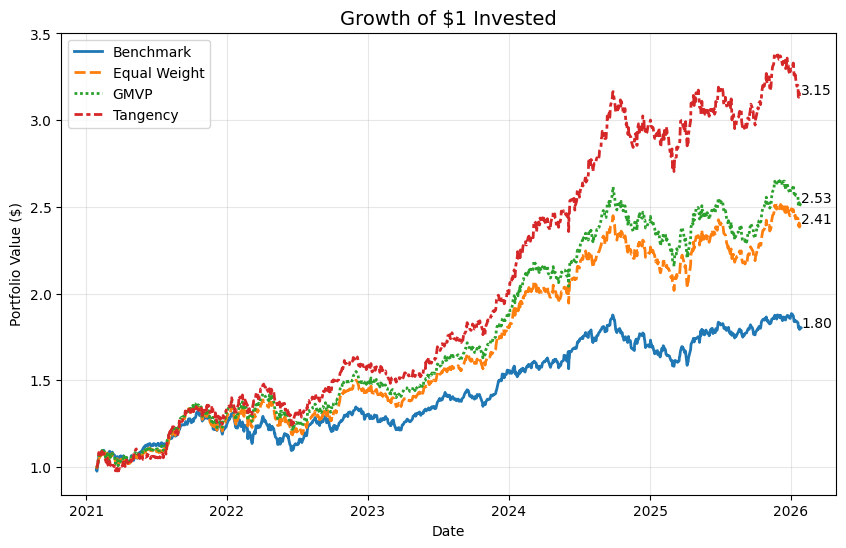

In [22]:
# Cell 9: Portfolio Value Over Time (Growth of $1)

# Compute cumulative portfolio value
gmvp_value = np.exp((returns @ gmvp).cumsum())
tan_value  = np.exp((returns @ tan).cumsum())
equal_value = np.exp((returns @ ew).cumsum())
benchmark_value = np.exp(benchmark_returns.cumsum())

portfolio_values = pd.DataFrame({
    "Benchmark": benchmark_value,
    "Equal Weight": equal_value,
    "GMVP": gmvp_value,
    "Tangency": tan_value,
})

# Plot
sns.lineplot(data=portfolio_values, linewidth=2)
plt.title("Growth of $1 Invested", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(alpha=0.3)

# Annotate final values
for col in portfolio_values.columns:
    plt.text(
        portfolio_values.index[-1], 
        portfolio_values[col].iloc[-1], 
        f"{portfolio_values[col].iloc[-1]:.2f}", 
        fontsize=10
    )

plt.show()


This plot shows the cumulative growth of a $1 investment in the Benchmark, Equal weighted, GMVP, and Tangency portfolios. By compounding log returns over time, it provides an intuitive comparison of long-term performance, highlighting how different risk–return strategies translate into actual portfolio value.

## 7. CAPM: Security Market Line (SML)

The Capital Asset Pricing Model (CAPM) links a stock’s expected return to its systematic risk (beta). The Security Market Line (SML) visually represents this relationship.

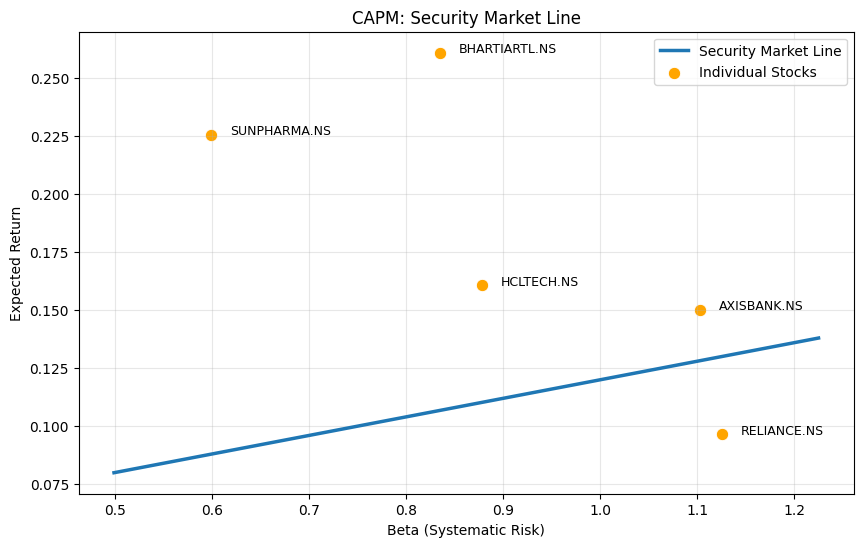

In [23]:
# Cell 10: CAPM – Security Market Line (SML)

# Compute beta for each stock vs benchmark
betas = {}
for asset in returns.columns:
    aligned = pd.concat([returns[asset], benchmark_returns], axis=1).dropna()
    cov = aligned.cov().iloc[0, 1]
    var = aligned.iloc[:, 1].var()
    betas[asset] = cov / var

betas = pd.Series(betas)

# Security Market Line
beta_range = np.linspace(betas.min() - 0.1, betas.max() + 0.1, 100)
sml = rf + beta_range * (bench_r - rf)

plt.plot(beta_range, sml, linewidth=2.5, label="Security Market Line")
sns.scatterplot(x=betas, y=mu, s=80, label="Individual Stocks", color="orange")

# Annotate each stock
for asset in betas.index:
    plt.text(betas[asset] + 0.02, mu[asset], asset, fontsize=9)

plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.title("CAPM: Security Market Line")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Interpretation:

- Above SML → stock offers higher return than expected for its risk (potentially undervalued)
- Below SML → stock offers lower return than expected for its risk (potentially overvalued)
- SML slope shows the reward per unit of market risk

In [24]:
# Cell 11: Top 5 Highest Beta Stocks

# Identify top 5 riskiest stocks by beta
top_beta_stocks = betas.sort_values(ascending=False).head(5)

top_beta_summary = pd.DataFrame({
    "Beta": top_beta_stocks,
    "Expected Return": mu[top_beta_stocks.index]
}).round(4)

display(top_beta_summary)


,Beta,Expected Return
RELIANCE.NS,1.1253,0.0965
AXISBANK.NS,1.1026,0.1501
HCLTECH.NS,0.8780,0.1607
BHARTIARTL.NS,0.8344,0.2610
SUNPHARMA.NS,0.5986,0.2256


Stocks with β > 1 are more volatile than the market, while β < 1 indicates defensive behavior.

In [30]:
import numpy
import pandas
import matplotlib
import seaborn
import scipy
import yfinance
import yaml
import jupyter
import platform

print("python:", platform.python_version())
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", seaborn.__version__)
print("SciPy:", scipy.__version__)
print("yfinance:", yfinance.__version__)
print("PyYAML:", yaml.__version__)


python: 3.12.10
NumPy: 2.3.4
Pandas: 2.3.3
Matplotlib: 3.10.7
Seaborn: 0.13.2
SciPy: 1.16.3
yfinance: 0.2.66
PyYAML: 6.0.3
